# Úkoly 
1. vykreslete grafy prvních 5 Legendrových polynomů na intervalu [-1,1]

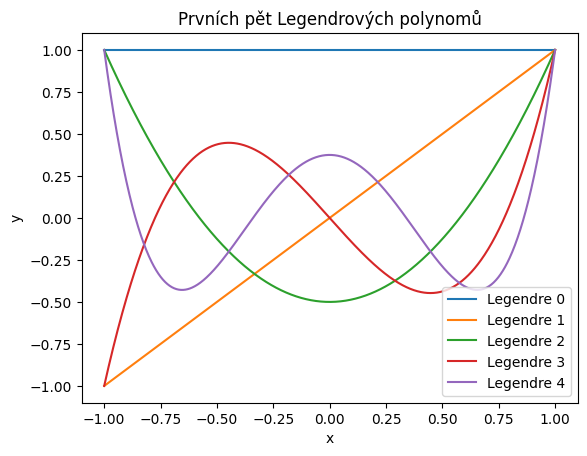

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre

x = np.linspace(-1, 1, 1000)

for n in range(5):
    y = legendre(n)(x)
    plt.plot(x, y, label=f"Legendre {n}")
    
plt.legend()
plt.title("Prvních pět Legendrových polynomů")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


2. vyrobte sparse matici reprezentující čtvercovou síť o velikosti $n \times n$, kde každá buňka sítě odpovídá jednomu řádku/sloupci matice. V každém řádku/sloupci matice jsou nuly, kromě diagonálního prvku s hodnotou $1 + k \cdot \varepsilon$ (kde $k$ určuje počet sousedních buněk = 4 uvnitř, 3 na hranách, 2 v rozích) a prvků odpovídajícím sousedním buňkám (nahoře, dole, vlevo, vpravo) s hodnotou $-\varepsilon$. Pořadí buněk čtvrtcové sítě berte po řádcích. Sestavte matici pomocí formátu LIL a vyplňte hodnoty pomocí cyklu přes všechny buňky sítě.
    - tedy matice má velikost $n^2 \times n^2$
    - $\varepsilon$ je parametr, který můžete nastavit, například $\varepsilon = 0.1$
    - matice je symetrická, tj. $A = A^T$
    - každý řádek/sloupec má maximálně 5 nenulových prvků
        - 5, pokud se jedná o buňku unvitř sítě
        - 4, pokud se jedná o buňku na okraji sítě
        - 3, pokud se jedná o buňku v rohu sítě
    - výsledná matice je 5-ti diagonální

Pro $n=3$ a $\varepsilon = 0.1$ by měla matice (v plné formě) měla vypadat následovně:
```python
[[ 1.2 -0.1  0.  -0.1  0.   0.   0.   0.   0. ]
 [-0.1  1.3 -0.1  0.  -0.1  0.   0.   0.   0. ]
 [ 0.  -0.1  1.2  0.   0.  -0.1  0.   0.   0. ]
 [-0.1  0.   0.   1.3 -0.1  0.  -0.1  0.   0. ]
 [ 0.  -0.1  0.  -0.1  1.4 -0.1  0.  -0.1  0. ]
 [ 0.   0.  -0.1  0.  -0.1  1.3  0.   0.  -0.1]
 [ 0.   0.   0.  -0.1  0.   0.   1.2 -0.1  0. ]
 [ 0.   0.   0.   0.  -0.1  0.  -0.1  1.3 -0.1]
 [ 0.   0.   0.   0.   0.  -0.1  0.  -0.1  1.2]]
 ```


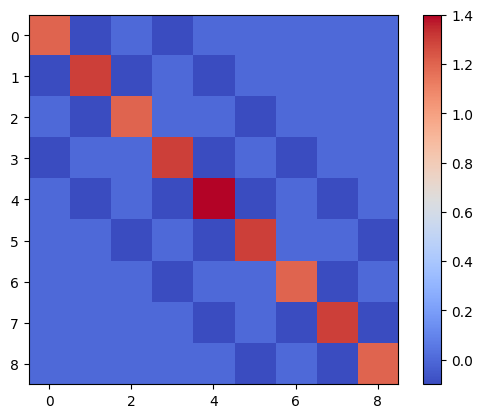

In [51]:
import scipy.sparse as sparse
import matplotlib.pyplot as plt

def get_epsilon_factor(i, j, n):
    if i == 0 or i == n-1:
        if j == 0 or j == n-1:
            return 2
        else:
            return 3
    elif j == 0 or j == n-1:
        return 3
    else:
        return 4

n = 3
epsilon = 1e-1
A = sparse.lil_matrix((n*n, n*n))

for i in range(n):
    for j in range(n):
        index = i * n + j
        A[index, index] = 1 + get_epsilon_factor(i, j, n) * epsilon
        if j > 0:
            A[index, index-1] = -epsilon
        if j < n-1:
             A[index, index+1] = -epsilon
        if i > 0:
            A[index, index-n] = -epsilon
        if i < n-1:
            A[index, index+n] = -epsilon

#print(A.todense())
plt.imshow(A.todense(), cmap='coolwarm')
plt.colorbar()
plt.show()

3. sestavte matici $A$ z předchozího úkolu pomocí indexů řádků, sloupců a hodnot ve formátu CSR. 
    - Tedy sestavte tři pole: `row`, `col` a `data`, které obsahují řádky, sloupce a hodnoty nenulových prvků matice 
        - separátně sestavte příspěvky které vzniknou konektivitou na vnitřních horizontálních hranách a na vnitřních vertikálních hranách.
            - při procházení všech vnitřních horizontálních hran si rozmyslete jaké jsou vždy indexy nad a pod hranou (toto jsou souřadnice řádků a sloupců)
            - totéž pro vnitřní vertikální hrany zde se může hodit `np.arange(n * n).reshape((n, n)).T.flatten()` což vytvoří vektor s přeházenými indexy
        - zvlášť sestavte příspevky pro mimodiagonální prvky a diagonální prvky.
            - u diagonálních prvků, nejprve vyrobte vektor hodnot $1+ 4\cdot \varepsilon$ a pak pro každou hranu odečtěte $\varepsilon$.
    - Tyto pole vytvořte vektorizovaně - bez cyklů
    - Využíjte vlastnosti, že hodnoty se stejnými indexy se při sestavení sečtou.

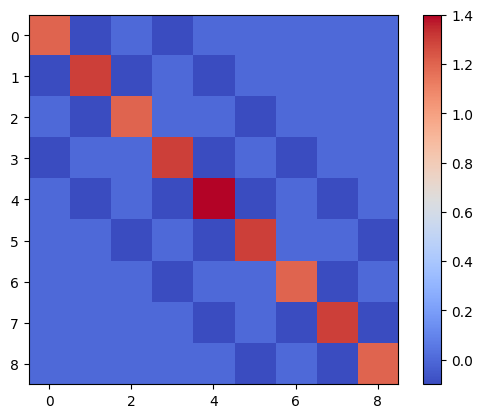

In [52]:
import numpy as np
from scipy.sparse import csr_matrix

n = 3
epsilon = 0.1

def A_efficiently(n, epsilon):
    ## --- Mimodiagonální prvky
    # Vnitřní horizontální hrany
    horizontal_up_idx = np.arange(0, (n*(n-1)), 1)
    horizontal_low_idx = np.arange(n, (n * n), 1)
    row_horizontal = np.hstack((horizontal_up_idx, horizontal_low_idx))
    col_horizontal = np.hstack((horizontal_low_idx, horizontal_up_idx))
    data_horizontal = -epsilon * np.ones(2 * (n * n - n))

    # Vnitřní vertikální hrany
    index_matrix_vertical = np.arange(n * n).reshape((n, n)).T.flatten() # indexy buněk přeházené pro vertikální hranu
    vertical_left_idx = index_matrix_vertical[:-n]
    vertical_right_idx = index_matrix_vertical[n:]
    row_vertical = np.hstack((vertical_left_idx, vertical_right_idx))
    col_vertical = np.hstack((vertical_right_idx, vertical_left_idx))
    data_vertical = -epsilon * np.ones(2 * (n * n - n))

    ## --- Diagonála (všechny prvky)
    diagonal_idx = np.arange(n * n)
    row_idx_diag = diagonal_idx
    col_idx_diag = diagonal_idx
    data_diag = (1 + 4 * epsilon) * np.ones(n * n)

    # odečteme epsilon pro každou z hran
    # horní hrana
    data_diag[:n] -= epsilon
    # dolní hrana
    data_diag[-n:] -= epsilon
    # levá hrana
    data_diag[::n] -= epsilon
    # pravá hrana
    data_diag[n-1::n] -= epsilon

    ## --- spojení všech vektorů a sestavení matice
    # spojíme všechny vnitřní hrany a diagonálu
    row = np.hstack((row_idx_diag, row_horizontal, row_vertical))
    col = np.hstack((col_idx_diag, col_horizontal, col_vertical))
    data = np.hstack((data_diag, data_horizontal, data_vertical))

    # vyrobíme matici
    A_efficiently = csr_matrix((data, (row, col)), shape=(n*n, n*n))

    return A_efficiently

#print(A_efficiently(n, epsilon).todense())
A = A_efficiently(n, epsilon)
plt.imshow(A.todense(), cmap='coolwarm')
plt.colorbar()
plt.show()


[0 1 2 3 4 5]
[3 4 5 6 7 8]
[0 1 2 3 4 5 3 4 5 6 7 8]
[3 4 5 6 7 8 0 1 2 3 4 5]


4. Použijte matici $A$ z předchozích úkolů. Vytvořte (použijte níže vytvořený) vektor $b$ odpovídající čtvercové síti s nulami všude kromě malého čtverce uprostřed ($n/6$ okolo středu) s hodnotou 1. 
    - Vykreslete řešení $x$ systému $A \cdot x = b$ jako obrázek čtvercové sítě
    - Spočtěte a vizualizujte 3 vlastní vektory matice $A$ (vlastní vektory odpovídající největším vlastním hodnotám) - opět jako obrázek čtvercové sítě

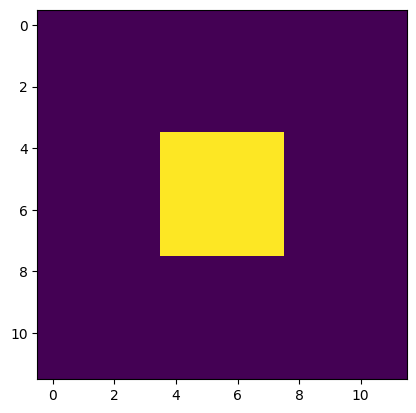

In [53]:
import matplotlib.pyplot as plt

n = 12
epsilon = 2e-1
A = A_efficiently(n, epsilon)

b = np.zeros((n, n))
b[n//2 - n//6:n//2 + n//6,n//2 - n//6:n//2 + n//6] = 1
b = b.flatten()
plt.imshow(b.reshape((n, n)))

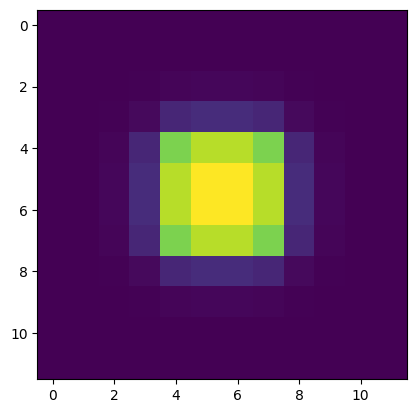

In [56]:
import scipy.sparse.linalg as spla

x = spla.spsolve(A, b)

x = x.reshape((n, n))
plt.imshow(x)
plt.show()

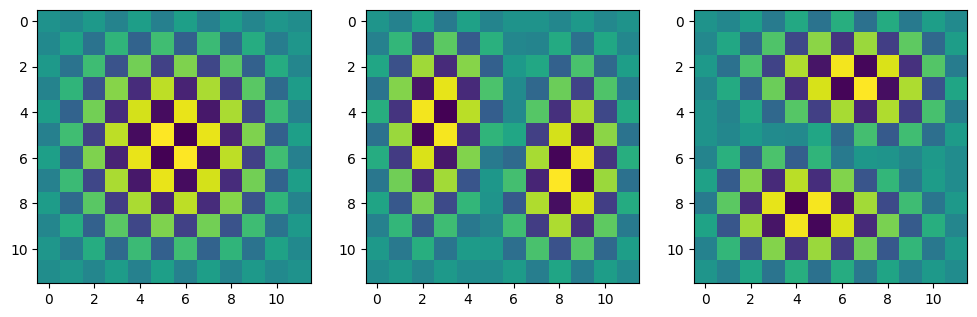

In [55]:
num_eigs = 3
eigvals, eigvecs = spla.eigs(A, k=num_eigs, which='LM')

eigvecs_real = np.real(eigvecs)
eig1, eig2, eig3 = eigvecs_real[:, 0], eigvecs_real[:, 1], eigvecs_real[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(eig1.reshape((n, n)))
axs[1].imshow(eig2.reshape((n, n)))
axs[2].imshow(eig3.reshape((n, n)))
plt.show()


5. Nalezněte všechny kořeny Legendrova polynomu stupně 5 na intervalu $<-1,1>$

In [14]:
from scipy.special import roots_legendre

n = 5
num_roots = n

roots, tmp = roots_legendre(num_roots)

for i in range(num_roots):
    print(f"{roots[i]:.6f}")


-0.906180
-0.538469
0.000000
0.538469
0.906180


6. Pomocí SymPy nalezněte všechny kořeny Legendrova polynomu stupně 5. Použíjte `sympy.legendre()` pro vytvoření výrazu odpovídajícímu Legendrovu polynomu.
- porovnejte výsledky s předchozím úkolem

In [18]:
import sympy as sp

x = sp.Symbol('x')
legendre_5 = sp.legendre(5, x)
legendre_5 = sp.solve(legendre_5, x)

print(legendre_5)


[0, -sqrt(5/9 - 2*sqrt(70)/63), sqrt(5/9 - 2*sqrt(70)/63), -sqrt(2*sqrt(70)/63 + 5/9), sqrt(2*sqrt(70)/63 + 5/9)]


In [ ]:
#výsledky jsou stejné